#Load data from kaggle

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kiendo206","key":"4d05d6e986d87918c6e868497d9bdb88"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'dogs-vs-cats'

 99% 808M/812M [00:06<00:00, 212MB/s]
100% 812M/812M [00:06<00:00, 131MB/s]


In [ ]:
import zipfile
import warnings
warnings.filterwarnings("ignore")

with zipfile.ZipFile("/content/dogs-vs-cats.zip","r") as z:
    z.extractall(".")


In [ ]:
import zipfile
import warnings
warnings.filterwarnings("ignore")

with zipfile.ZipFile("/content/train.zip","r") as z:
    z.extractall(".")

#Prepare data and library

Install required packages

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00


Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from skimage.feature import hog,SIFT
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cluster import KMeans
from catboost import Pool,CatBoostClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from mlxtend.plotting import plot_decision_regions
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    recall_score,
    confusion_matrix,
    precision_score,
    f1_score,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = '/content/train/'

filenames = os.listdir(data_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(0) #dog=0
    else:
        categories.append(1) #cat=1

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.8762.jpg,0
1,dog.6757.jpg,0
2,dog.11484.jpg,0
3,cat.3660.jpg,1
4,dog.12179.jpg,0


<Axes: >

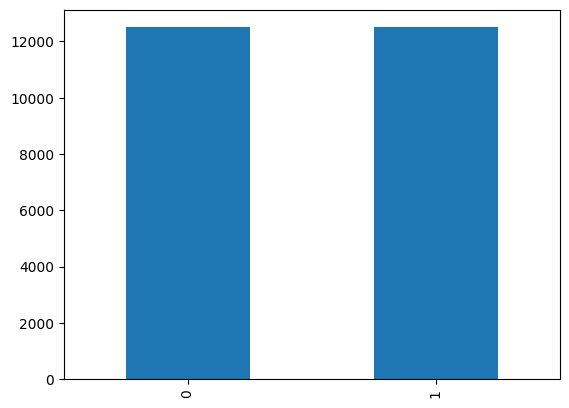

In [ ]:
df['category'].value_counts().plot.bar()

12500 images of dogs and 12500 images of cats


Show a random image

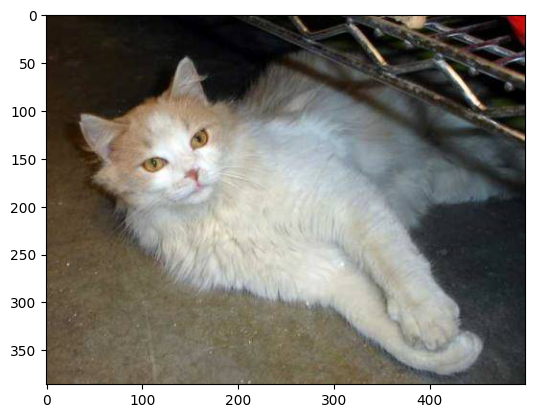

In [ ]:
sample = random.choice(filenames)
image = plt.imread(data_path+sample)
plt.imshow(image)

Show the largest and smallest image

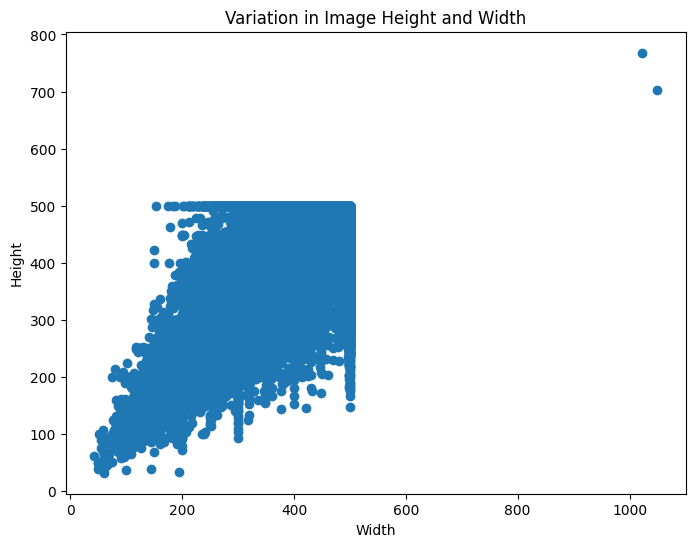

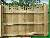

(50, 38)


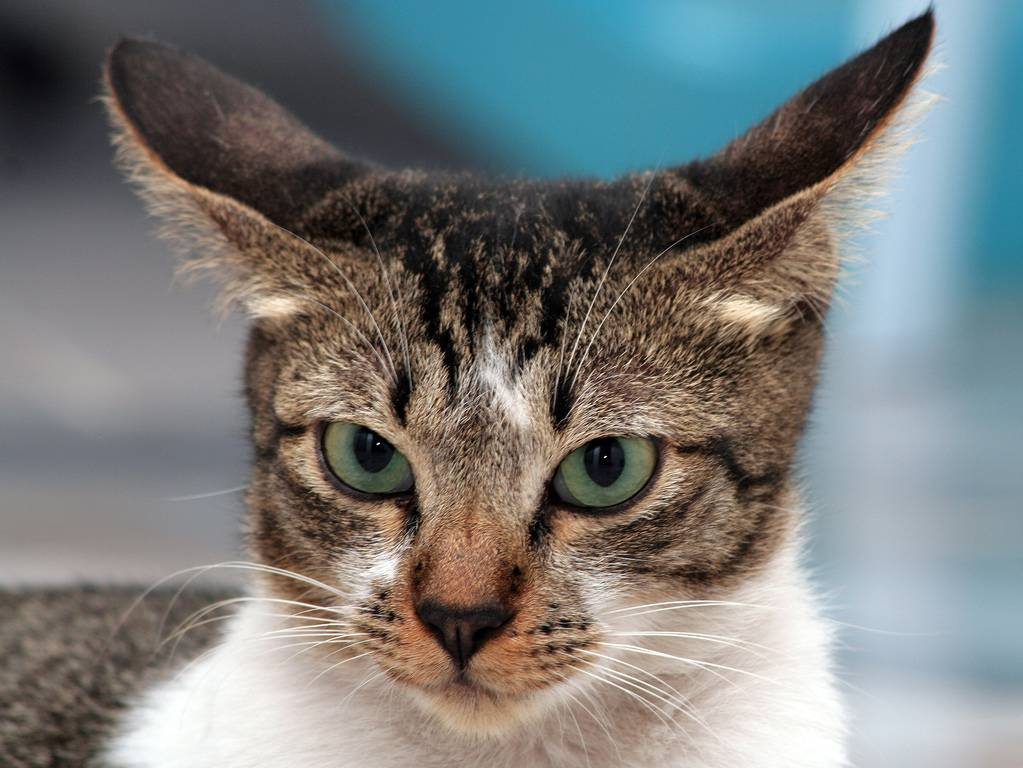

(1023, 768)


In [ ]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def find_smallest_and_largest_resolutions(directory):
    # Get a list of all image files in the directory
    image_files = [filename for filename in os.listdir(directory) if filename.endswith(('.png', '.jpg', '.jpeg'))]

    smallest_resolution = None
    largest_resolution = None
    smallest_image = None
    largest_image = None
    heights = []
    widths = []

    # Iterate over each image file
    for filename in image_files:
        image_path = os.path.join(directory, filename)

        try:
            # Read the image using cv2
            img = cv2.imread(image_path)

            # Get the resolution of the image
            height, width, _ = img.shape
            resolution = (width, height)
            heights.append(height)
            widths.append(width)
            # Update the smallest and largest resolutions
            if smallest_resolution is None or (width * height) < (smallest_resolution[0] * smallest_resolution[1]):
                smallest_resolution = resolution
                smallest_image = img
            if largest_resolution is None or (width * height) > (largest_resolution[0] * largest_resolution[1]):
                largest_resolution = resolution
                largest_image = img
        except Exception as e:
            print(f"Error processing image '{filename}': {e}")
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Variation in Image Height and Width')
    plt.show()
    return smallest_image, largest_image, smallest_resolution, largest_resolution

# Provide the directory path containing the images
image_directory = '/content/train'
smallest_image, largest_image, smallest_res, largest_res = find_smallest_and_largest_resolutions(image_directory)

if smallest_image is not None:
    cv2_imshow(smallest_image)
    print(smallest_res)

if largest_image is not None:
    cv2_imshow(largest_image)
    print(largest_res)


Some noises in our data

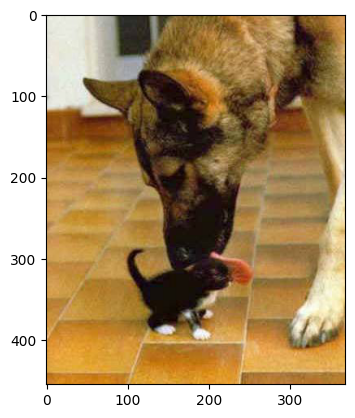

In [ ]:
nse = 'cat.724.jpg'
image = plt.imread(data_path+nse)
plt.imshow(image)

Split data

In [ ]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'})
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df.head()

,filename,category
0,dog.3313.jpg,dog
1,cat.3183.jpg,cat
2,cat.6947.jpg,cat
3,cat.1047.jpg,cat
4,cat.1940.jpg,cat


#Preprocessing

Some parameters

In [ ]:
img_size = 150
batch_size = 50
epoch = 50

In [ ]:
from skimage.feature import hog
#Feature extraction
def get_hog_features(img, orient=8, pix_per_cell=16, cell_per_block=4,vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec,channel_axis=-1)
    else: # Otherwise call with one output
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True, visualize=vis, feature_vector=feature_vec,channel_axis=-1)

        return features

Get data from dataframe

In [ ]:
def input_processing(dframe):
    X=[]
    y=[]
    for filename in dframe["filename"]:
        img=cv2.imread(data_path + filename)
        img=cv2.resize(img,(img_size,img_size))
        img=img.astype('float32')
        #get hog feature
        img_hog=get_hog_features(img)
        X.append(img_hog)
        y.append(filename[:3])
    X=np.array(X)
    y=LabelEncoder().fit_transform(y) # encode cat = 0 và dog=1
    return X,y

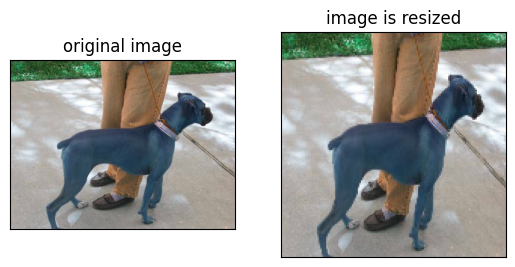

In [ ]:
#print image before and after resize
for filename in train_df['filename']:
  img=cv2.imread(data_path+filename)
  plt.subplot(1,2,1)
  fig1=plt.imshow(img)
  plt.title('original image')
  fig1.axes.get_xaxis().set_visible(False)
  fig1.axes.get_yaxis().set_visible(False)
  img=cv2.resize(img,(img_size,img_size))
  plt.subplot(1,2,2)
  fig2=plt.imshow(img)
  plt.title('image is resized')
  fig2.axes.get_xaxis().set_visible(False)
  fig2.axes.get_yaxis().set_visible(False)
  break

In [ ]:
print(img.shape)

(150, 150, 3)


In [ ]:
X_train,y_train=input_processing(train_df)
X_test,y_test=input_processing(validate_df)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(20000, 4608)
(20000,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(5000, 4608)
(5000,)


random data to tune ( origin data is very large so The original data is very large, so it takes a lot of time to tune)

In [ ]:
X_train_tune,X_train_remain,y_train_tune,y_train_remain=train_test_split(X_train,y_train,train_size=0.1,random_state=42)
X_test_tune,X_test_remain,y_test_tune,y_test_remain=train_test_split(X_test,y_test,train_size=0.1,random_state=42)

In [ ]:
print(len(np.where(np.array(y_train_tune==0))[0])/2000)
print(len(np.where(np.array(y_test_tune==0))[0])/500)

0.4775
0.5


#Model

##KNN

In [ ]:
def train_and_test_knn(k_arr):
  for k in k_arr:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_tune, y_train_tune)
    y_pred_tune = knn.predict(X_test_tune)
    report = classification_report(y_test_tune, y_pred_tune, target_names=['dog','cat'], digits=3, output_dict=True)
    print('k={}'.format(k))
    print('Accuracy: {}'.format(report['accuracy']))
    print('Precision for cats: {}'.format(report['cat']['precision']))
    print('Precision for dogs: {}'.format(report['dog']['precision']))
    print('Recall for cats: {}'.format(report['cat']['recall']))
    print('Recall for dogs: {}'.format(report['dog']['recall']))
    print('F1 Score for cats: {}'.format(report['cat']['f1-score']))
    print('F1 Score for dogs: {}'.format(report['dog']['f1-score']))

In [ ]:
train_and_test_knn(range(1,5))

k=1
Accuracy: 0.608
Precision for cats: 0.6928571428571428
Precision for dogs: 0.575
Recall for cats: 0.388
Recall for dogs: 0.828
F1 Score for cats: 0.4974358974358974
F1 Score for dogs: 0.6786885245901638
k=2
Accuracy: 0.6
Precision for cats: 0.6157407407407407
Precision for dogs: 0.5880281690140845
Recall for cats: 0.532
Recall for dogs: 0.668
F1 Score for cats: 0.5708154506437768
F1 Score for dogs: 0.6254681647940075
k=3
Accuracy: 0.594
Precision for cats: 0.7701149425287356
Precision for dogs: 0.5569007263922519
Recall for cats: 0.268
Recall for dogs: 0.92
F1 Score for cats: 0.3976261127596439
F1 Score for dogs: 0.6938159879336352
k=4
Accuracy: 0.604
Precision for cats: 0.696969696969697
Precision for dogs: 0.5706521739130435
Recall for cats: 0.368
Recall for dogs: 0.84
F1 Score for cats: 0.481675392670157
F1 Score for dogs: 0.6796116504854369


In [ ]:
train_and_test_knn([i*10 for i in range(1,5)])

k=10
Accuracy: 0.604
Precision for cats: 0.8714285714285714
Precision for dogs: 0.5604651162790698
Recall for cats: 0.244
Recall for dogs: 0.964
F1 Score for cats: 0.38125
F1 Score for dogs: 0.7088235294117647
k=20
Accuracy: 0.584
Precision for cats: 0.9375
Precision for dogs: 0.5464601769911505
Recall for cats: 0.18
Recall for dogs: 0.988
F1 Score for cats: 0.30201342281879195
F1 Score for dogs: 0.7037037037037037
k=30
Accuracy: 0.562
Precision for cats: 0.9696969696969697
Precision for dogs: 0.5331905781584583
Recall for cats: 0.128
Recall for dogs: 0.996
F1 Score for cats: 0.22614840989399293
F1 Score for dogs: 0.694560669456067
k=40
Accuracy: 0.556
Precision for cats: 0.9666666666666667
Precision for dogs: 0.5297872340425532
Recall for cats: 0.116
Recall for dogs: 0.996
F1 Score for cats: 0.20714285714285716
F1 Score for dogs: 0.6916666666666667


In [ ]:
train_and_test_knn([i*100 for i in range(1,5)])

k=100
Accuracy: 0.546
Precision for cats: 0.96
Precision for dogs: 0.5242105263157895
Recall for cats: 0.096
Recall for dogs: 0.996
F1 Score for cats: 0.17454545454545453
F1 Score for dogs: 0.6868965517241379
k=200
Accuracy: 0.542
Precision for cats: 1.0
Precision for dogs: 0.5219206680584552
Recall for cats: 0.084
Recall for dogs: 1.0
F1 Score for cats: 0.15498154981549817
F1 Score for dogs: 0.6858710562414266
k=300
Accuracy: 0.528
Precision for cats: 1.0
Precision for dogs: 0.51440329218107
Recall for cats: 0.056
Recall for dogs: 1.0
F1 Score for cats: 0.10606060606060606
F1 Score for dogs: 0.6793478260869565
k=400
Accuracy: 0.52
Precision for cats: 1.0
Precision for dogs: 0.5102040816326531
Recall for cats: 0.04
Recall for dogs: 1.0
F1 Score for cats: 0.07692307692307693
F1 Score for dogs: 0.6756756756756758


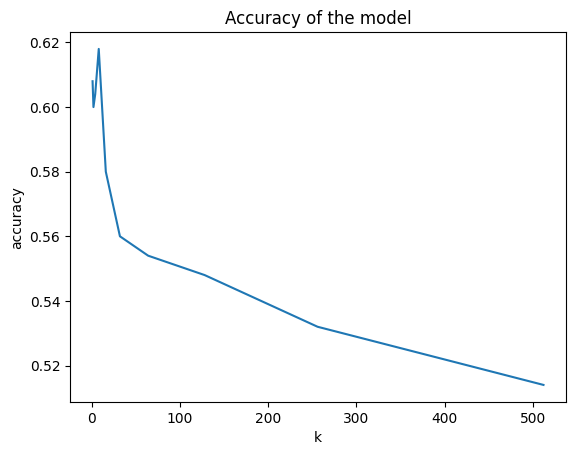

In [ ]:
k_arr = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
accu=[]

for k in k_arr:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_tune, y_train_tune)
    y_pred_tune = knn.predict(X_test_tune)
    accu.append(accuracy_score(y_pred_tune, y_test_tune))

plt.plot(k_arr,accu)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Accuracy of the model')
plt.show()

k=4
              precision    recall  f1-score   support

         dog      0.758     0.548     0.636      2588
         cat      0.626     0.812     0.707      2412

    accuracy                          0.675      5000
   macro avg      0.692     0.680     0.671      5000
weighted avg      0.694     0.675     0.670      5000



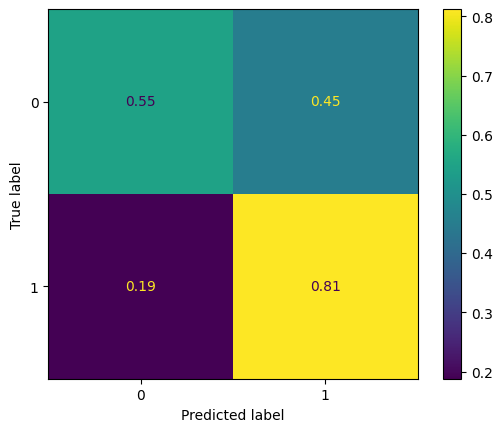

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('k=4')
print(classification_report(y_test, y_pred, target_names=['dog','cat'], digits=3))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#KNN + K-FOLD
pred_kfold = cross_val_score(knn, X_train, y_train, cv=5)
print("Accuracy with K-NN and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with K-NN and K-FOLD CROSS VALIDATION: 0.68 (+/- 0.01)


##SVM

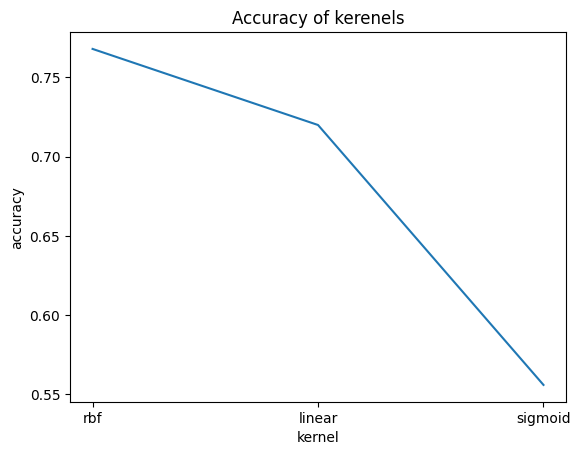

In [ ]:
accu=[]
kernel_name=[]
kernel_tune=['rbf','linear','sigmoid']
for i in kernel_tune:
  svm_model=SVC(kernel=i)
  svm_model.fit(X_train_tune,y_train_tune)
  test_pred_svm=svm_model.predict(X_test_tune)
  accu.append(accuracy_score(y_test_tune,test_pred_svm))
  kernel_name.append(i)
plt.plot(kernel_name,accu)
plt.xticks(rotation=0)
plt.xlabel('kernel')
plt.ylabel('accuracy')
plt.title('Accuracy of kerenels')
plt.show()

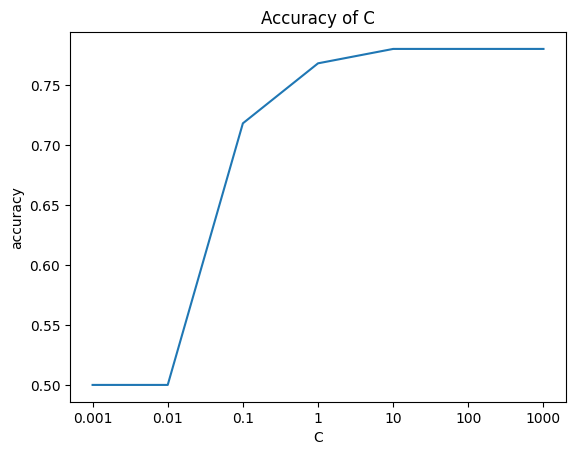

In [ ]:
accura=[]
C_para_name=[]
C_tune=[0.001,0.01,0.1,1,10,100,1000]
for i in C_tune:
  svm_model=SVC(kernel='rbf',C=i)
  svm_model.fit(X_train_tune,y_train_tune)
  test_pred_svm=svm_model.predict(X_test_tune)
  accura.append(accuracy_score(y_test_tune,test_pred_svm))
  C_para_name.append(f'{i}')
plt.plot(C_para_name,accura)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Accuracy of C')
plt.show()

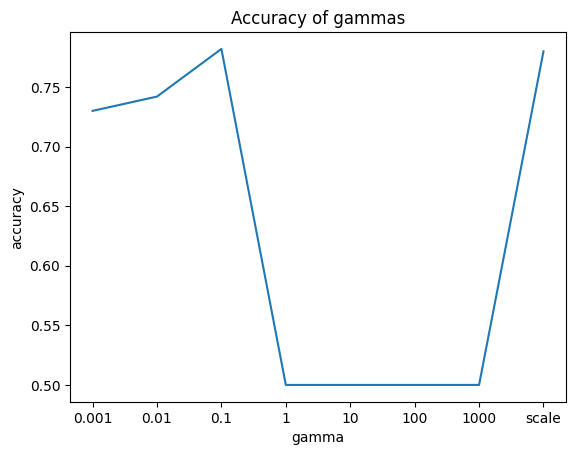

In [ ]:
accuracy=[]
gamma_name=[]
gamma_tune=[0.001,0.01,0.1,0.1,1,10,100,1000,'scale']
for i in gamma_tune:
  svm_model=SVC(kernel='rbf',C=10,gamma=i)
  svm_model.fit(X_train_tune,y_train_tune)
  test_pred_svm=svm_model.predict(X_test_tune)
  accuracy.append(accuracy_score(y_test_tune,test_pred_svm))
  gamma_name.append(f'{i}')
plt.plot(gamma_name,accuracy)
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.title('Accuracy of gammas')
plt.show()

In [ ]:
svm_model=SVC(kernel='rbf',C=10,gamma=0.1)
svm_model.fit(X_train,y_train)
train_pred_svm=svm_model.predict(X_train)
test_pred_svm=svm_model.predict(X_test)

In [ ]:
print(classification_report(y_train,train_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10037
           1       1.00      1.00      1.00      9963

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
print(classification_report(y_test,test_pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2463
           1       0.83      0.81      0.82      2537

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



# Gradient Boosting

In [ ]:
from catboost import CatBoostClassifier,Pool


In [ ]:
pool_train=Pool(X_train_tune,y_train_tune)
pool_test=Pool(X_test_tune)

In [ ]:
print(pool_train.shape)
print(pool_test.shape)

(2000, 4608)
(500, 4608)


Learning rate set to 0.216032
0:	learn: 0.6637850	total: 2.21s	remaining: 1m 48s
1:	learn: 0.6370826	total: 3.01s	remaining: 1m 12s
2:	learn: 0.6137119	total: 3.78s	remaining: 59.3s
3:	learn: 0.5937822	total: 4.57s	remaining: 52.6s
4:	learn: 0.5753650	total: 5.36s	remaining: 48.2s
5:	learn: 0.5607773	total: 6.13s	remaining: 44.9s
6:	learn: 0.5459734	total: 6.88s	remaining: 42.2s
7:	learn: 0.5349604	total: 7.65s	remaining: 40.2s
8:	learn: 0.5208893	total: 8.42s	remaining: 38.3s
9:	learn: 0.5071753	total: 9.2s	remaining: 36.8s
10:	learn: 0.4960158	total: 9.97s	remaining: 35.3s
11:	learn: 0.4846890	total: 11s	remaining: 34.8s
12:	learn: 0.4737840	total: 12.3s	remaining: 35s
13:	learn: 0.4624387	total: 13.1s	remaining: 33.7s
14:	learn: 0.4543831	total: 13.9s	remaining: 32.4s
15:	learn: 0.4450833	total: 14.7s	remaining: 31.2s
16:	learn: 0.4358707	total: 15.5s	remaining: 30s
17:	learn: 0.4258804	total: 16.2s	remaining: 28.9s
18:	learn: 0.4179734	total: 17s	remaining: 27.8s
19:	learn: 0.40809

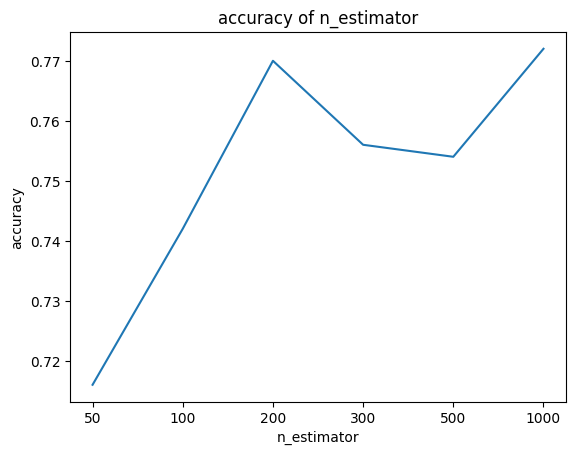

In [ ]:
n_estimator=[50,100,200,300,500,1000]
n_esti=[]
perform=[]
for i in n_estimator:
 cbc=CatBoostClassifier(iterations=i)
 cbc.fit(pool_train)
 test_pred_catboost=cbc.predict(pool_test)
 perform.append(accuracy_score(y_test_tune,test_pred_catboost))
 n_esti.append(f'{i}')
plt.plot(n_esti,perform)
plt.title('accuracy of n_estimator')
plt.xlabel('n_estimator')
plt.ylabel('accuracy')
plt.show()

0:	learn: 0.6929911	total: 1.25s	remaining: 20m 45s
1:	learn: 0.6928126	total: 2.03s	remaining: 16m 53s
2:	learn: 0.6926514	total: 2.83s	remaining: 15m 40s
3:	learn: 0.6924991	total: 3.64s	remaining: 15m 6s
4:	learn: 0.6923441	total: 4.42s	remaining: 14m 40s
5:	learn: 0.6922136	total: 5.21s	remaining: 14m 23s
6:	learn: 0.6920382	total: 5.98s	remaining: 14m 7s
7:	learn: 0.6918646	total: 7.27s	remaining: 15m 1s
8:	learn: 0.6916841	total: 8.44s	remaining: 15m 29s
9:	learn: 0.6915162	total: 9.25s	remaining: 15m 15s
10:	learn: 0.6913694	total: 10s	remaining: 15m 1s
11:	learn: 0.6911825	total: 10.8s	remaining: 14m 49s
12:	learn: 0.6910541	total: 11.6s	remaining: 14m 39s
13:	learn: 0.6909108	total: 12.4s	remaining: 14m 32s
14:	learn: 0.6907751	total: 13.2s	remaining: 14m 24s
15:	learn: 0.6906259	total: 14s	remaining: 14m 19s
16:	learn: 0.6904731	total: 14.8s	remaining: 14m 14s
17:	learn: 0.6903460	total: 15.6s	remaining: 14m 8s
18:	learn: 0.6901940	total: 16.4s	remaining: 14m 4s
19:	learn: 0.

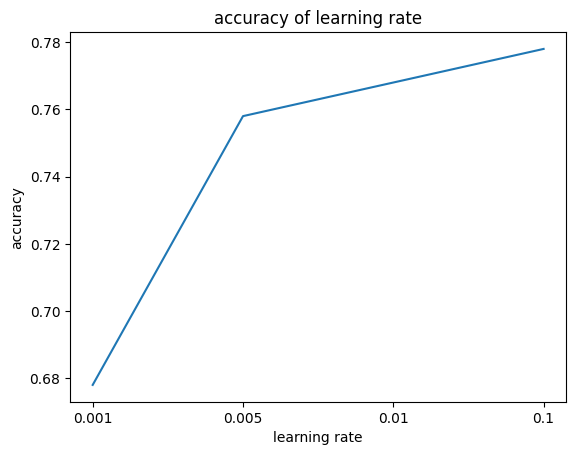

In [ ]:
lr=[0.001,0.005,0.01,0.1]
lr_value=[]
perform1=[]
for i in lr:
 cbc=CatBoostClassifier(iterations=1000,learning_rate=i)
 cbc.fit(pool_train)
 test_pred_catboost=cbc.predict(pool_test)
 perform1.append(accuracy_score(y_test_tune,test_pred_catboost))
 lr_value.append(f'{i}')
plt.plot(lr_value,perform1)
plt.title('accuracy of learning rate')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

In [ ]:
cbc=CatBoostClassifier(iterations=1000,learning_rate=0.1)
cbc.fit(Pool(X_train,y_train))
train_pred_cbc=cbc.predict(X_train)
test_pred_cbc=cbc.predict(Pool(X_test))

0:	learn: 0.6787916	total: 1.64s	remaining: 27m 17s
1:	learn: 0.6666077	total: 3.27s	remaining: 27m 12s
2:	learn: 0.6557131	total: 5.56s	remaining: 30m 48s
3:	learn: 0.6458222	total: 6.95s	remaining: 28m 49s
4:	learn: 0.6367693	total: 8.36s	remaining: 27m 43s
5:	learn: 0.6289383	total: 9.8s	remaining: 27m 4s
6:	learn: 0.6217896	total: 11.2s	remaining: 26m 30s
7:	learn: 0.6153831	total: 12.7s	remaining: 26m 10s
8:	learn: 0.6096752	total: 14.1s	remaining: 25m 49s
9:	learn: 0.6045474	total: 15.6s	remaining: 25m 43s
10:	learn: 0.5989539	total: 18s	remaining: 26m 56s
11:	learn: 0.5946772	total: 19.4s	remaining: 26m 38s
12:	learn: 0.5901715	total: 20.8s	remaining: 26m 19s
13:	learn: 0.5862133	total: 22.2s	remaining: 26m 3s
14:	learn: 0.5824440	total: 23.6s	remaining: 25m 50s
15:	learn: 0.5790155	total: 24.9s	remaining: 25m 32s
16:	learn: 0.5756401	total: 26.3s	remaining: 25m 21s
17:	learn: 0.5722800	total: 27.6s	remaining: 25m 6s
18:	learn: 0.5695209	total: 29.7s	remaining: 25m 31s
19:	learn

In [ ]:
print(classification_report(y_train,train_pred_cbc))

In [ ]:
print(classification_report(y_test,test_pred_cbc))

# Random Forest

In [ ]:
para_grid_rf_tune={'n_estimators':[50,100,200,500],
                   'max_depth':[2,4,6],
                   'max_features':['sqrt','log2'],
                   'max_leaf_nodes':[2,4,6]}
model_rf_grid=GridSearchCV(RFC(),para_grid_rf_tune,refit=True,verbose=3)
model_rf_grid.fit(X_train_tune,y_train_tune)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=50;, score=0.600 total time=   1.6s
[CV 2/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=50;, score=0.670 total time=   3.6s
[CV 3/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=50;, score=0.670 total time=   1.4s
[CV 4/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=50;, score=0.660 total time=   1.1s
[CV 5/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=50;, score=0.618 total time=   1.1s
[CV 1/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=100;, score=0.603 total time=   2.1s
[CV 2/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=100;, score=0.657 total time=   2.1s
[CV 3/5] END max_depth=2, max_features=sqrt, max_leaf_nodes=2, n_estimators=100;, score=0.690 total time=   2.2s
[CV 4/5] END max_depth=2, max_features=

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [2, 4, 6],
                         'n_estimators': [50, 100, 200, 500]},
             verbose=3)

In [ ]:
print(f'best para is {model_rf_grid.best_params_}')
print(f'best accuracy is {model_rf_grid.best_score_}')

best para is {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 200}
best accuracy is 0.6769999999999999


In [ ]:
rfc=RFC(max_depth=6,max_features='sqrt',max_leaf_nodes=6,n_estimators=200)
rfc.fit(X_train,y_train)
train_pred_rfc=rfc.predict(X_train)
test_pred_rfc=rfc.predict(X_test)

In [ ]:
print(classification_report(y_train,train_pred_rfc))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69     10037
           1       0.69      0.65      0.67      9963

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



In [ ]:
print(classification_report(y_test,test_pred_rfc))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2463
           1       0.70      0.65      0.68      2537

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



##KMeans

In [ ]:
# Since K-Means Does not know about our labels we have to change labels of k-means according to our usage

# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters,reference_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

In [ ]:
mbk = KMeans(init ='k-means++', n_clusters = 2,verbose = 0)
clusters = mbk.fit_predict(X_train)

In [ ]:
reference_labels = get_reference_dict(clusters,y_train)
predicted_labels = get_labels(clusters,reference_labels)

# Accuracy Score for right predictions
print(accuracy_score(predicted_labels,y_train))

0.50245


Accuracy for k = 2:  0.5225
Accuracy for k = 16:  0.626
Accuracy for k = 64:  0.6725
Accuracy for k = 100:  0.6555
Accuracy for k = 256:  0.6855


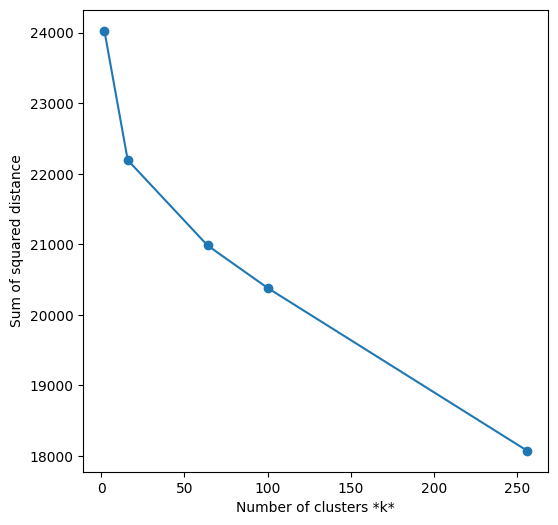

In [ ]:
# elbow method
# squared distance
sse = []
list_k = [2,16,64,100,256]

for k in list_k:
    #km = KMeans(n_clusters=k)
    km = KMeans(init ='k-means++', n_clusters = k, verbose = 0)
    clusters = km.fit_predict(X_train_tune)
    sse.append(km.inertia_)

    reference_labels = get_reference_dict(clusters,y_train_tune)
    predicted_labels = get_labels(clusters,reference_labels)

    print(f"Accuracy for k = {k}: ",
          accuracy_score(predicted_labels,y_train_tune))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

As you can see, the sum of squared distance is still dropped drastically at k = 256, so we choose our k = 256

In [ ]:
mbk = KMeans(init ='k-means++', n_clusters = 256,verbose = 0)
clusters = mbk.fit_predict(X_train)
reference_labels = get_reference_dict(clusters,y_train)
predicted_labels = get_labels(clusters,reference_labels)

              precision    recall  f1-score   support

         cat      0.719     0.679     0.699     10037
         dog      0.694     0.733     0.713      9963

    accuracy                          0.706     20000
   macro avg      0.707     0.706     0.706     20000
weighted avg      0.707     0.706     0.706     20000



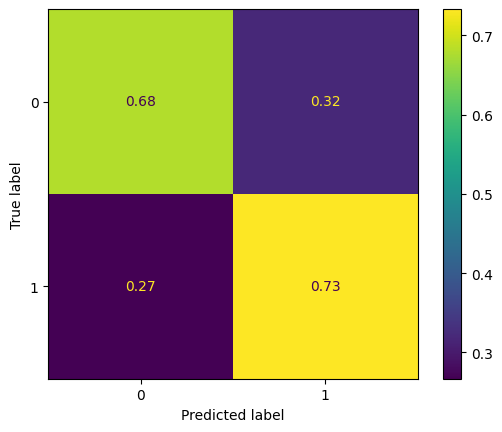

In [ ]:
print(classification_report(y_train, predicted_labels, target_names=['cat','dog'], digits=3))

cm = confusion_matrix(y_train, predicted_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##CNN

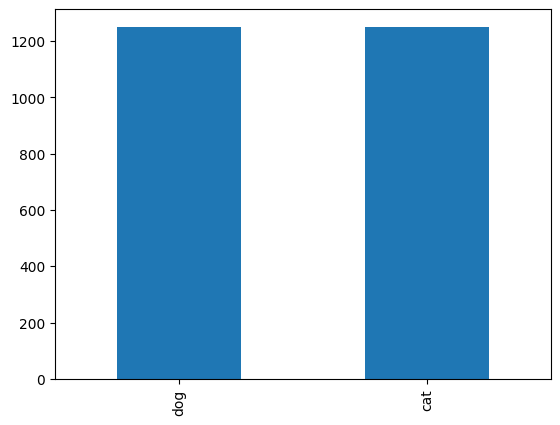

In [ ]:
data_path = '/content/train/'

filenames = os.listdir(data_path)
files = []
categories_tune = []
c = 0
d = 0
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        if d == 1250:
            continue
        files.append(filename)
        categories_tune.append('dog') #dog=0
        d=d+1
    else:
        if c == 1250:
            continue
        files.append(filename)
        categories_tune.append('cat') #cat=1
        c=c+1
df_tune = pd.DataFrame({
    'filename': files,
    'category': categories_tune
})
df_tune['category'].value_counts().plot.bar()
train_df_tune, validate_df_tune = train_test_split(df_tune, test_size=0.20, random_state=42)
train_df_tune = train_df_tune.reset_index(drop=True)
validate_df_tune = validate_df_tune.reset_index(drop=True)

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_data = train_generator.flow_from_dataframe(
    train_df,
    data_path,
    x_col='filename',
    y_col='category',
    target_size=(img_size,img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

train_data_tune = train_generator.flow_from_dataframe(
    train_df_tune,
    data_path,
    x_col='filename',
    y_col='category',
    target_size=(img_size,img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_dataframe(
    validate_df,
    data_path,
    x_col='filename',
    y_col='category',
    target_size=(img_size, img_size),
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)
test_data_tune = test_generator.flow_from_dataframe(
    validate_df_tune,
    data_path,
    x_col='filename',
    y_col='category',
    target_size=(img_size, img_size),
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

Found 5000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
model0 = Sequential()

model0.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model0.add(MaxPooling2D(pool_size=(2, 2)))


model0.add(Conv2D(64, (3, 3), activation='relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))


model0.add(Conv2D(128, (3, 3), activation='relu'))
model0.add(MaxPooling2D(pool_size=(2, 2)))


model0.add(Flatten())
model0.add(Dense(512, activation='relu'))

model0.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)      

Model comparison

Epoch 1/50
40/40 [==============================] - 39s 690ms/step - loss: 0.7788 - accuracy: 0.5295 - val_loss: 0.6339 - val_accuracy: 0.6280
Epoch 2/50
40/40 [==============================] - 19s 473ms/step - loss: 0.6657 - accuracy: 0.5970 - val_loss: 0.5954 - val_accuracy: 0.6900
Epoch 3/50
40/40 [==============================] - 18s 443ms/step - loss: 0.6462 - accuracy: 0.6335 - val_loss: 0.5889 - val_accuracy: 0.7040
Epoch 4/50
40/40 [==============================] - 19s 470ms/step - loss: 0.6420 - accuracy: 0.6290 - val_loss: 0.5680 - val_accuracy: 0.6920
Epoch 5/50
40/40 [==============================] - 19s 473ms/step - loss: 0.6102 - accuracy: 0.6705 - val_loss: 0.6015 - val_accuracy: 0.6600
Epoch 6/50
40/40 [==============================] - 18s 456ms/step - loss: 0.6028 - accuracy: 0.6785 - val_loss: 0.5421 - val_accuracy: 0.7220
Epoch 7/50
40/40 [==============================] - 18s 443ms/step - loss: 0.5889 - accuracy: 0.6845 - val_loss: 0.5086 - val_accuracy: 0.7720

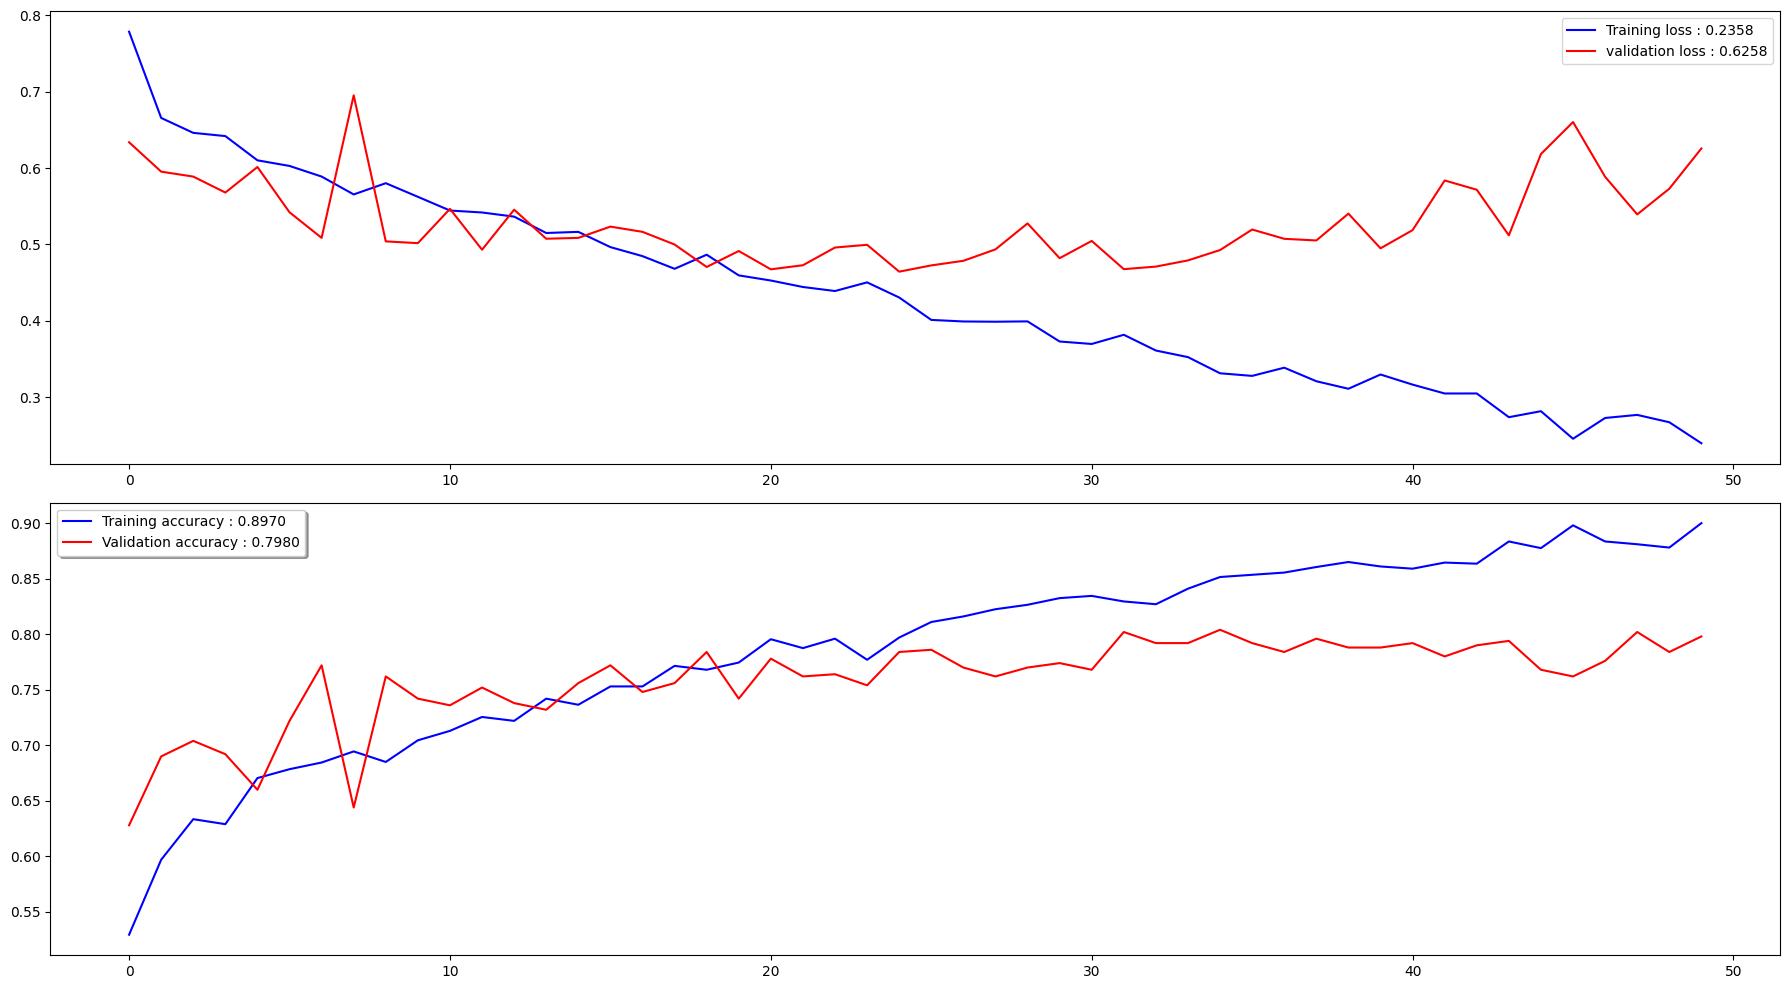

In [ ]:
hist0 = model0.fit_generator(train_data_tune,
                    epochs=epoch,
                    validation_data=test_data_tune,
                    shuffle=True,
                    )
train_acc_tune = model0.evaluate(train_data_tune)
test_acc_tune = model0.evaluate(test_data_tune)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(hist0.history['loss'], color='b', label="Training loss : {:0.4f}".format(train_acc_tune[0]))
ax1.plot(hist0.history['val_loss'], color='r', label="validation loss : {:0.4f}".format(test_acc_tune[0]))
ax1.legend()

ax2.plot(hist0.history['accuracy'], color='b', label="Training accuracy : {0:.4f}".format(train_acc_tune[1]))
ax2.plot(hist0.history['val_accuracy'], color='r',label="Validation accuracy : {0:.4f}".format(test_acc_tune[1]))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Epoch 1/50
40/40 [==============================] - 23s 482ms/step - loss: 1.1914 - accuracy: 0.5685 - val_loss: 5.4321 - val_accuracy: 0.4600
Epoch 2/50
40/40 [==============================] - 19s 482ms/step - loss: 0.8801 - accuracy: 0.6115 - val_loss: 5.9758 - val_accuracy: 0.4600
Epoch 3/50
40/40 [==============================] - 18s 456ms/step - loss: 0.8241 - accuracy: 0.6275 - val_loss: 4.2193 - val_accuracy: 0.4600
Epoch 4/50
40/40 [==============================] - 19s 463ms/step - loss: 0.7387 - accuracy: 0.6470 - val_loss: 4.3561 - val_accuracy: 0.4600
Epoch 5/50
40/40 [==============================] - 19s 477ms/step - loss: 0.6938 - accuracy: 0.6715 - val_loss: 1.0839 - val_accuracy: 0.4600
Epoch 6/50
40/40 [==============================] - 18s 451ms/step - loss: 0.6681 - accuracy: 0.6775 - val_loss: 2.3018 - val_accuracy: 0.4600
Epoch 7/50
40/40 [==============================] - 19s 480ms/step - loss: 0.6430 - accuracy: 0.6785 - val_loss: 2.2552 - val_accuracy: 0.4600

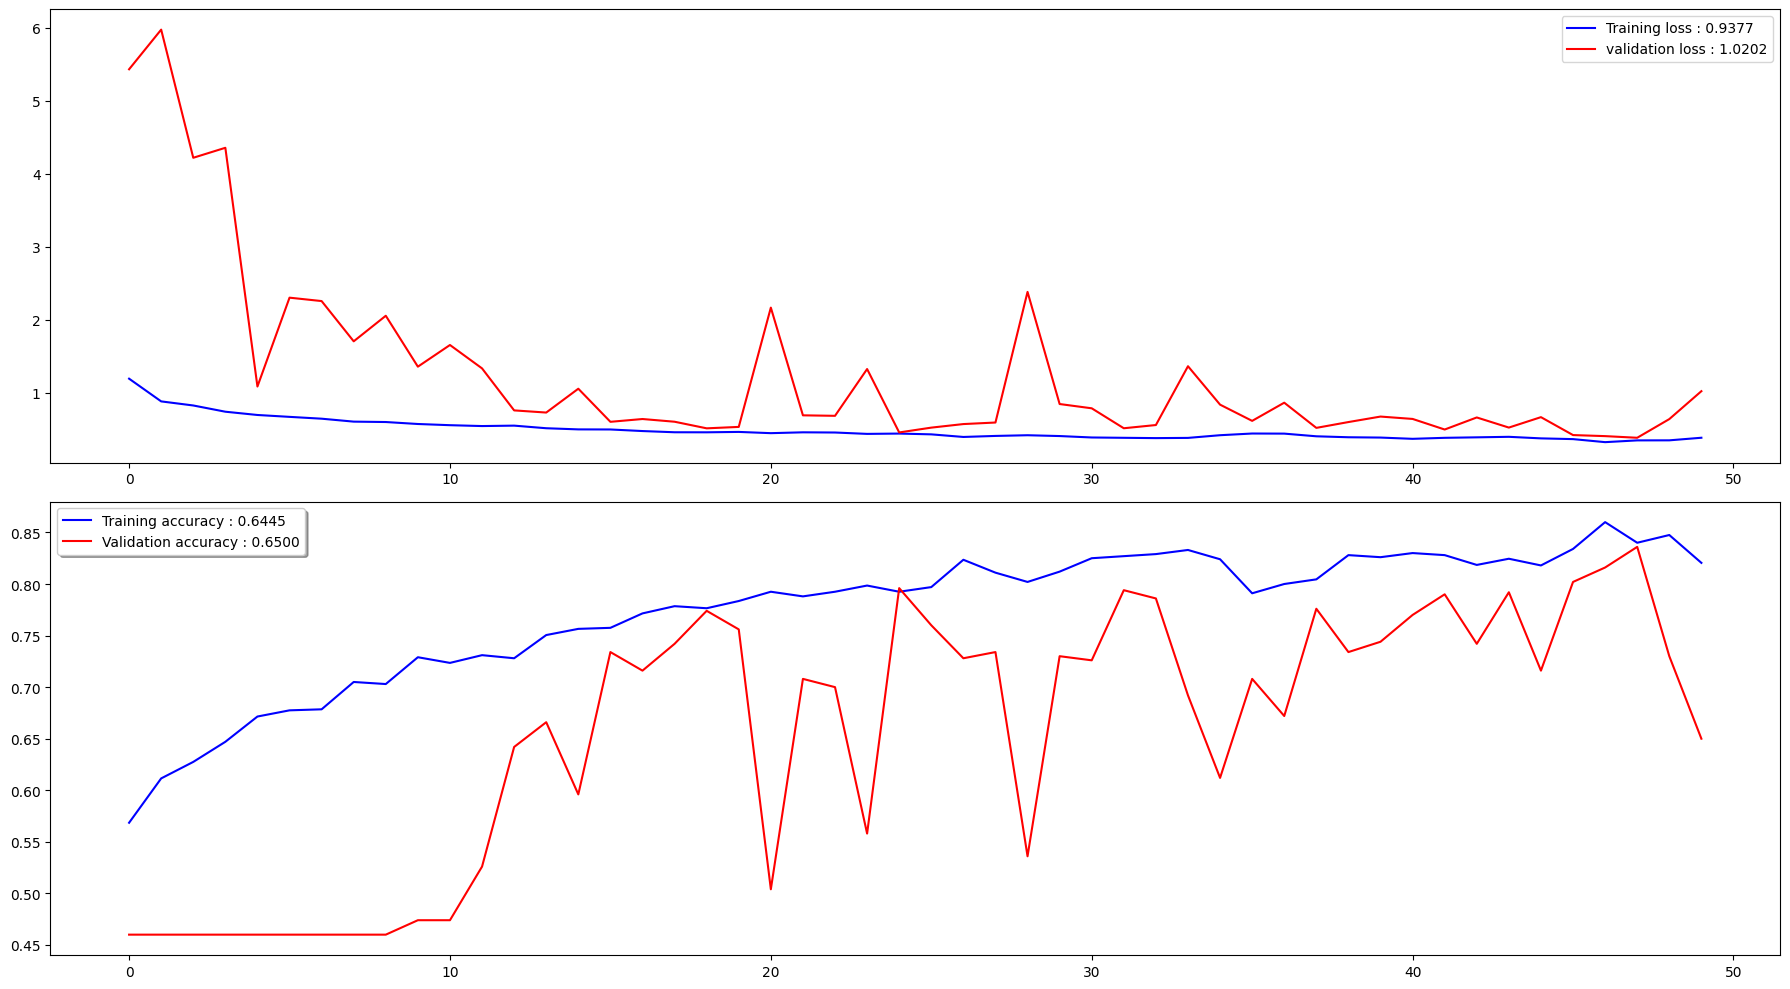

In [ ]:
hist = model.fit_generator(train_data_tune,
                    epochs=epoch,
                    validation_data=test_data_tune,
                    shuffle=True,
                    )
train_acc_tune = model.evaluate(train_data_tune)
test_acc_tune = model.evaluate(test_data_tune)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(hist.history['loss'], color='b', label="Training loss : {:0.4f}".format(train_acc_tune[0]))
ax1.plot(hist.history['val_loss'], color='r', label="validation loss : {:0.4f}".format(test_acc_tune[0]))
ax1.legend()

ax2.plot(hist.history['accuracy'], color='b', label="Training accuracy : {0:.4f}".format(train_acc_tune[1]))
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy : {0:.4f}".format(test_acc_tune[1]))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Main model with full data

In [ ]:
history = model.fit_generator(train_data,
                    epochs=epoch,
                    validation_data=test_data,
                    shuffle=True,
                    )

Epoch 1/50
400/400 [==============================] - 188s 470ms/step - loss: 0.5460 - accuracy: 0.7244 - val_loss: 0.5817 - val_accuracy: 0.7372
Epoch 2/50
400/400 [==============================] - 179s 449ms/step - loss: 0.4897 - accuracy: 0.7604 - val_loss: 0.5699 - val_accuracy: 0.7520
Epoch 3/50
400/400 [==============================] - 180s 450ms/step - loss: 0.4534 - accuracy: 0.7875 - val_loss: 0.8120 - val_accuracy: 0.7532
Epoch 4/50
400/400 [==============================] - 179s 447ms/step - loss: 0.4269 - accuracy: 0.8044 - val_loss: 0.7756 - val_accuracy: 0.6394
Epoch 5/50
400/400 [==============================] - 179s 448ms/step - loss: 0.4028 - accuracy: 0.8178 - val_loss: 0.4876 - val_accuracy: 0.7932
Epoch 6/50
400/400 [==============================] - 179s 448ms/step - loss: 0.3825 - accuracy: 0.8263 - val_loss: 0.6090 - val_accuracy: 0.7766
Epoch 7/50
400/400 [==============================] - 184s 460ms/step - loss: 0.3620 - accuracy: 0.8419 - val_loss: 0.3469 -

In [ ]:
train_acc = model.evaluate(train_data)
test_acc = model.evaluate(test_data)

100/100 [==============================] - 16s 159ms/step - loss: 0.1903 - accuracy: 0.9254


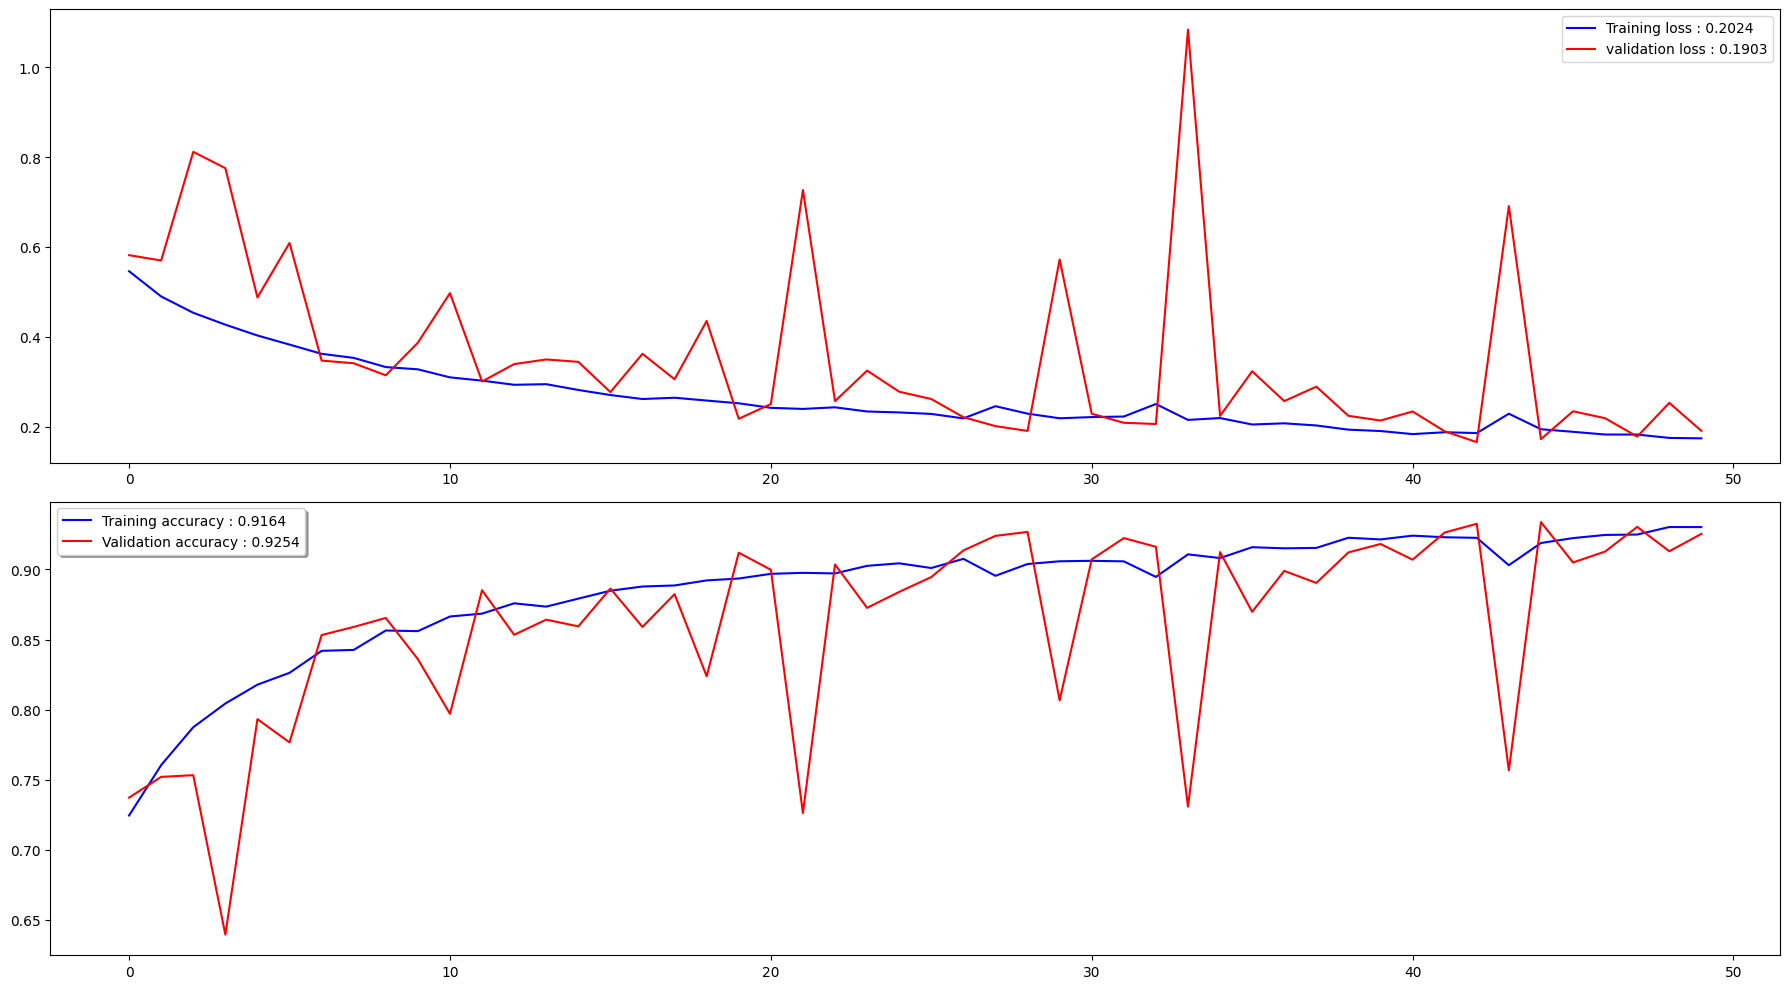

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss : {:0.4f}".format(train_acc[0]))
ax1.plot(history.history['val_loss'], color='r', label="validation loss : {:0.4f}".format(test_acc[0]))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy : {0:.4f}".format(train_acc[1]))
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy : {0:.4f}".format(test_acc[1]))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

100/100 [==============================] - 16s 161ms/step
              precision    recall  f1-score   support

         cat      0.909     0.952     0.930      2588
         dog      0.945     0.897     0.921      2412

    accuracy                          0.925      5000
   macro avg      0.927     0.924     0.925      5000
weighted avg      0.926     0.925     0.925      5000



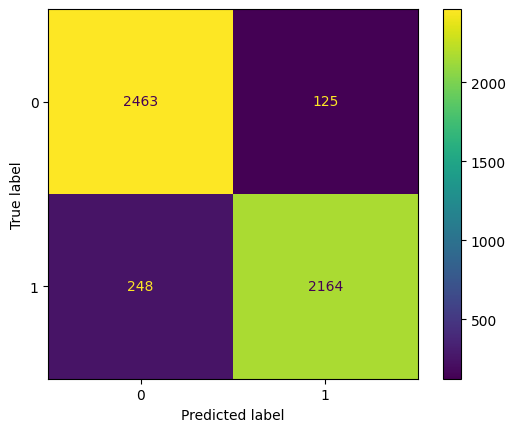

In [ ]:
predictions = model.predict(test_data)
print(classification_report(y_true=test_data.classes, y_pred=np.argmax(predictions, axis=-1), target_names=['cat','dog'], digits=3))
cm = confusion_matrix(y_true=test_data.classes, y_pred=np.argmax(predictions, axis=-1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Save model

In [ ]:
model.save('project1.h5')
print('Model Saved!')

In [ ]:
#savedModel=load_model('project.h5')